# Counterfactuals

In [69]:
# libraries
library(rstan)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
library(brms)
library(loo)
library(haven)
library(sdazar)
library(data.table)
library(MASS)
library(stringr)

library(bayesplot)
library(forcats)
library(ggplot2)
library(patchwork)
options(repr.plot.width = 5, repr.plot.height = 3)
source('Rutils/functions.R')

In [47]:
# load data
df = data.table(read_stata('../data/LA_uncertainty.dta'))

df = df[, .(ctry, year, gdp_pc, median)]
setnames(df, c('gdp_pc', 'median'), c('gdp', 'le'))
df = df[complete.cases(df)] # remove rows with missing data

df[, le_log := scale(log(le), scale=FALSE)]
df[, gdp_log := scale(log(gdp), scale=FALSE)]
df[, year_log := scale(log(year), scale=FALSE)]

In [48]:
# year recode based on the criteria proposed by Alberto
df[year<1950, gyear:=1]
df[year>=1950 & year<1970, gyear:=2]
df[year>=1970 & year<1990, gyear:=3]
df[year>=1990, gyear :=4]
df[, gyear := factor(gyear, levels=1:4, labels=c('1950', '1950-1969', '1970-1989', '1990'))]
df[, ctry := factor(ctry)]

In [49]:
table(df$gyear, useNA='ifany') # discrete groups of year


     1950 1950-1969 1970-1989      1990 
      103        76        76        88 

In [50]:
# transform variable: weibull
df[, y := le/max(le+1.05), by = ctry] # adjustment is by country!
df[, wy := log(-log(1-y))]
max_le = df[, .(max_le = max(le+1.05)), by = ctry]

In [51]:
# function
get_orig_values_weibull = function(x, max_value) { 
    return ( (1 - exp(-exp(x))) * max_value )
}

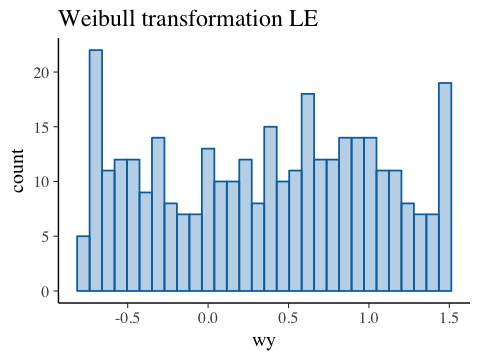

In [52]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(df, aes(wy)) +
    geom_histogram(bins=30, color='#0072B2', fill='#0072B2', alpha=0.3) +
    labs(title='Weibull transformation LE')

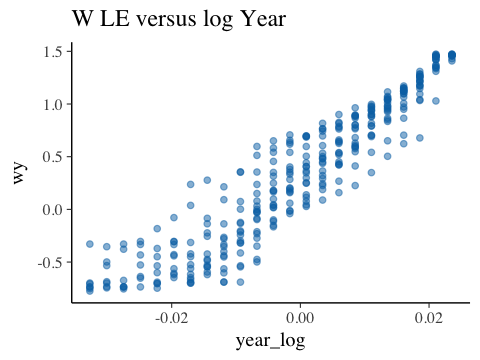

In [53]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(df, aes(y=wy, x=year_log)) + geom_point(alpha=0.5, color='#0072B2') +
    labs(title='W LE versus log Year')

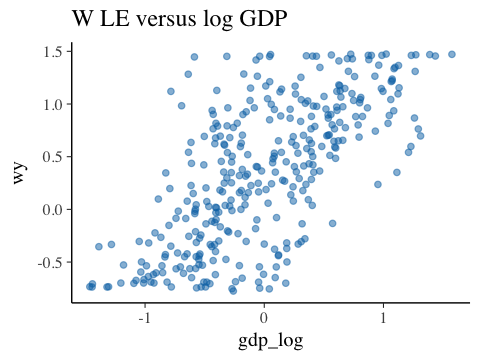

In [54]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(df, aes(y=wy, x=gdp_log)) + geom_point(alpha=0.5, color='#0072B2') +
    labs(title='W LE versus log GDP')

### Counterfactuals

- I create a variable resulting from the combination of country and year
- I specify country-year random intercept and GDP random coefficient

In [275]:
# check sample sizes
df[, ctry_year := interaction(ctry, gyear)]
# table(df$ctry_year)

In [56]:
w1 = brm(formula = wy ~ 1 + gdp_log +  (gdp_log|ctry_year), 
    data = df, control=list(adapt_delta=0.85))

Compiling the C++ model
Start sampling


In [57]:
summary(w1)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: wy ~ 1 + gdp_log + (gdp_log | ctry_year) 
   Data: df (Number of observations: 343) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~ctry_year (Number of levels: 73) 
                       Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)              0.47      0.05     0.39     0.57       1032 1.00
sd(gdp_log)                0.25      0.08     0.07     0.41        404 1.01
cor(Intercept,gdp_log)     0.02      0.26    -0.46     0.57       2052 1.00

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept     0.41      0.06     0.29     0.52        710 1.00
gdp_log       0.74      0.06     0.62     0.86       1598 1.00

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     0.15      0.01    

### Fit

In [338]:
pred = cbind(df[, .(ctry, year, le, year_log, gdp_log, le_log)], predict(w1))
setnames(pred, c('Estimate', '2.5%ile', '97.5%ile'), c('m', 'lo', 'hi'))

In [339]:
max_value_le = max_le[ctry==2020, max_le]

In [340]:
pred = merge(pred, max_le, by = 'ctry')
pred[,  `:=` (
    m = get_orig_values_weibull(m, max_value_le), 
    lo = get_orig_values_weibull(lo, max_value_le),
    hi = get_orig_values_weibull(hi, max_value_le)
    )]

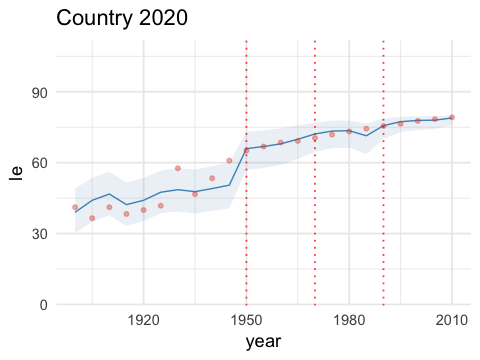

In [343]:
ggplot(pred[ctry==2020], aes(x=year, y=le)) + 
    geom_line(aes(y=m), color='#2b8cbe', size = 0.4)  +
    geom_ribbon(aes(ymin = lo, ymax = hi), fill = '#a6bddb', alpha=0.2)  + 
    geom_point(size=1, color='#e34a33', alpha=0.4) +
    labs(title=paste0('Country ', countries[i])) + 
        ylim(min(df$le)-25.0, max(df$le)+25.0) + 
        xlim(min(df$year), max(df$year)) + theme_minimal() + 
    geom_vline(xintercept = 1950, size=0.5, color='red', alpha=0.8, linetype = 'dotted') +
    geom_vline(xintercept = 1970, size=0.5, color='red', alpha=0.8, linetype = 'dotted') +
    geom_vline(xintercept = 1990, size=0.5, color='red', alpha=0.8, linetype = 'dotted') 

### Counterfactuals 2020

- Counterfactual $E(t)$ for 1950 but using parameter estimates for 1970-1990: 
    - What are predicted values of $E(t)$ for 1950 if the model parameter we use is for the period 1970-1990? 
    - Call them $E1(1950)$. The difference between this predicted value and the predicted values using estimates from the model for before 1950, $E(50)$, is the $SHIFT(1950)$

In [325]:
# extract posterior samples of population-level effects 
samples <- posterior_samples(w1)

In [326]:
# function to estimate shifts
estimate_shift = function(samples, country=NULL, 
                          year_groups=c('1950', '1970-1989'),
                          gdp_value = NULL, max_le_value = NULL,
                          coefficients = c('Intercept', 'gdp_log')) {

    pred = list()
    colnames = names(samples)
    betas = paste0('b_', coefficients)
    
    
    for (i in seq_along(year_groups)) {
        random = str_subset(colnames, paste0('^r_.+\\[', country, '.', year_groups[i], ','))
        s = samples[, c(betas, random)]
        pred[[i]] = s[,1] + s[,3] + (s[,2] + s[,4]) * gdp_value
        pred[[i]] = unlist(sapply(pred[[i]], 
                                  function(x) get_orig_values_weibull(x, max_value=max_le_value)))
        
    }
     return (pred[[2]]-pred[[1]])
}

In [327]:
pred50 = estimate_shift(samples, country=2020, 
                     gdp_value = df[ctry==2020 & year==1950, gdp_log], 
                      max_le_value=max_le[ctry==2020, max_le])

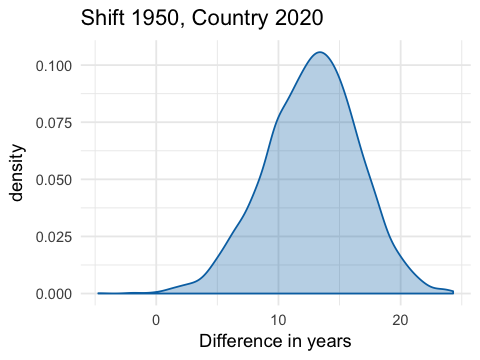

In [328]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(data.frame(pred50), aes(pred50))  + geom_density(color='#0072B2', fill='#0072B2', alpha=0.3) +
#     geom_vline(xintercept = le_obs, color='red') + 
    labs(title='Shift 1950, Country 2020', 
        x='Difference in years') + 
    theme_minimal()

- Counterfactual $E(t)$ for 1970 but using parameter estimates for 1970-1990: 
    - what are predicted values of $E(t)$ for 1970 if the model parameter we use is for the period 1970-1990? Call them E2(1970). 
    - The difference between these predicted values with predicted values using estimates from the model for period 1970-1990 (this should 1950-1969 right?), $E(1970)$, is the $SHIFT(1970)$

**I don't get this, I should use 1950-1969?**

In [329]:
pred70 = estimate_shift(samples, country=2020,
                        year_groups=c('1950-1969','1970-1989'),
                        gdp_value = df[ctry==2020 & year==1970, gdp_log], 
                        max_le_value=max_le[ctry==2020, max_le])

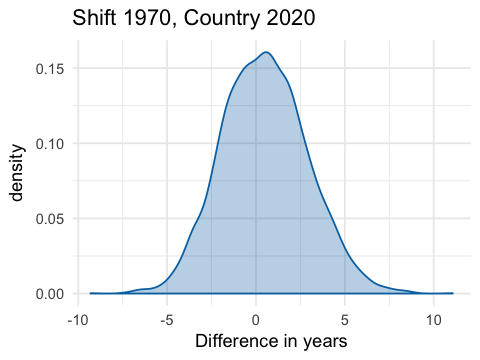

In [332]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(data.frame(pred70), aes(pred70))  + geom_density(color='#0072B2', fill='#0072B2', alpha=0.3) +
#     geom_vline(xintercept = le_obs, color='red') + 
    labs(title='Shift 1970, Country 2020', 
        x='Difference in years') + 
    theme_minimal()

- Counterfactual $E(t)$ for 1990 but using parameter estimates for 1990-2015: 

    - What are predicted values of E(t) for 1970 (this should be 1990 right?) if the model parameter we use is for the period 1990-2015? Call them E3(1990).
    - The difference between these predicted values with predicted values using estimates for period 1990-2015 (this should be 1970-1989 right?), E(1990), is the SHIFT(1990)

In [334]:
pred90 = estimate_shift(samples, country=2020,
                        year_groups=c('1970-1989','1990'),
                        gdp_value = df[ctry==2020 & year==1990, gdp_log], 
                        max_le_value=max_le[ctry==2020, max_le])

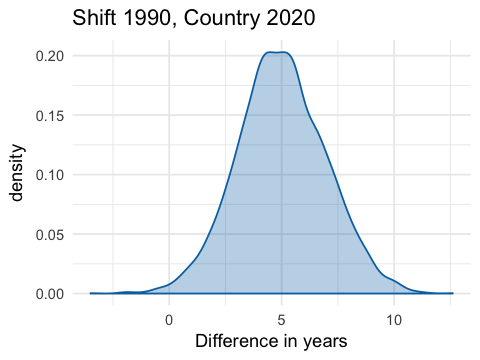

In [335]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(data.frame(pred90), aes(pred90))  + geom_density(color='#0072B2', fill='#0072B2', alpha=0.3) +
#     geom_vline(xintercept = le_obs, color='red') + 
    labs(title='Shift 1990, Country 2020', 
        x='Difference in years') + 
    theme_minimal()